# **Libraries**



In [136]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression



# **Loading and viewing the dataset**

In [137]:
stroke_df = pd.read_csv('/content/healthcare-dataset-stroke-data.csv')
print(stroke_df.head())
print(stroke_df.info())


      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 e

#  Data exploration and summary statistics

                 id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000    5110.000000   
mean   36517.829354    43.226614      0.097456       0.054012   
std    21161.721625    22.612647      0.296607       0.226063   
min       67.000000     0.080000      0.000000       0.000000   
25%    17741.250000    25.000000      0.000000       0.000000   
50%    36932.000000    45.000000      0.000000       0.000000   
75%    54682.000000    61.000000      0.000000       0.000000   
max    72940.000000    82.000000      1.000000       1.000000   

       avg_glucose_level          bmi       stroke  
count        5110.000000  4909.000000  5110.000000  
mean          106.147677    28.893237     0.048728  
std            45.283560     7.854067     0.215320  
min            55.120000    10.300000     0.000000  
25%            77.245000    23.500000     0.000000  
50%            91.885000    28.100000     0.000000  
75%           114.090000    33.100000     0

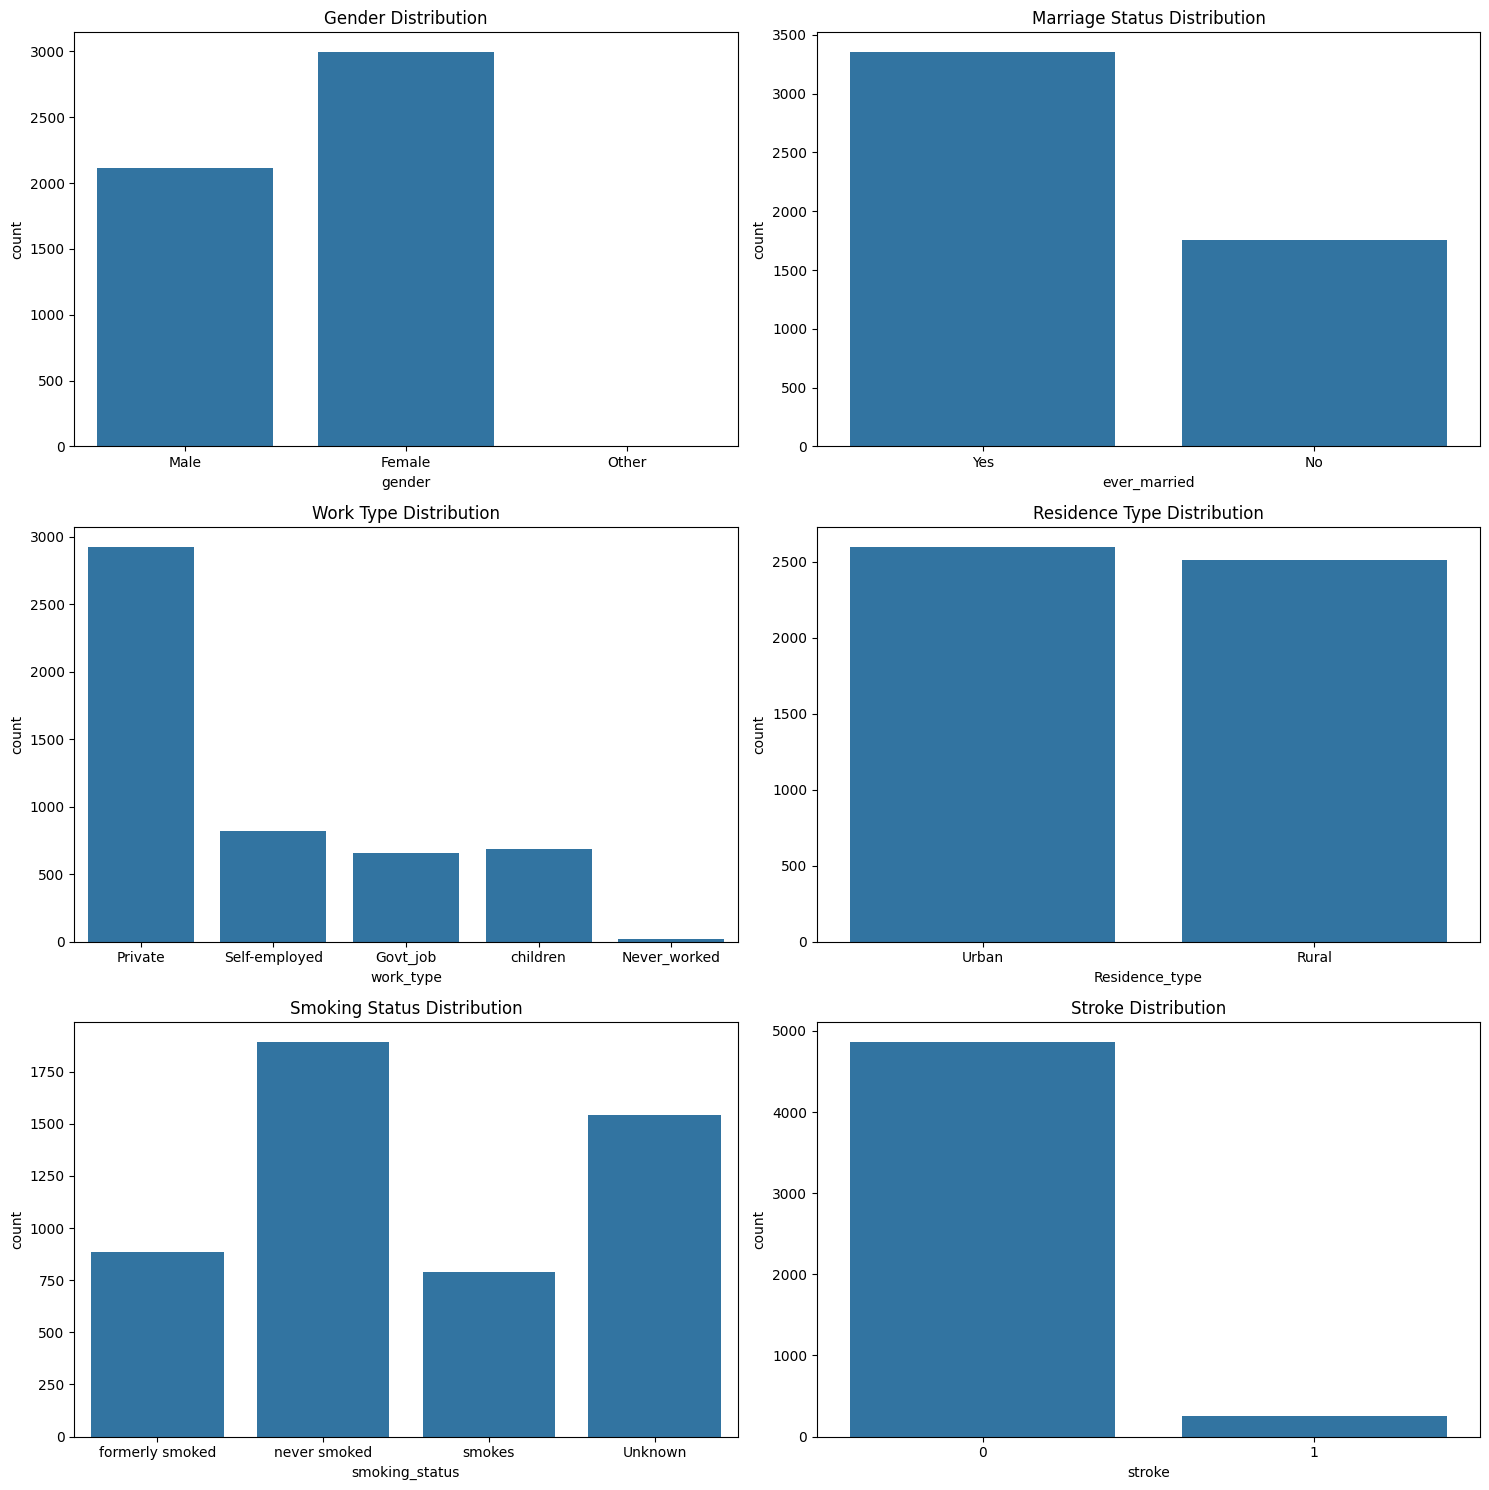

In [138]:
print(stroke_df.describe())
print(stroke_df.isnull().sum())
print(f"Duplicated entries: {stroke_df.duplicated().sum()}")

# Count plots for categorical variables
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
sns.countplot(x='gender', data=stroke_df, ax=axes[0, 0]).set_title('Gender Distribution')
sns.countplot(x='ever_married', data=stroke_df, ax=axes[0, 1]).set_title('Marriage Status Distribution')
sns.countplot(x='work_type', data=stroke_df, ax=axes[1, 0]).set_title('Work Type Distribution')
sns.countplot(x='Residence_type', data=stroke_df, ax=axes[1, 1]).set_title('Residence Type Distribution')
sns.countplot(x='smoking_status', data=stroke_df, ax=axes[2, 0]).set_title('Smoking Status Distribution')
sns.countplot(x='stroke', data=stroke_df, ax=axes[2, 1]).set_title('Stroke Distribution')
plt.tight_layout()
plt.show()


# **Missing data heatmap**

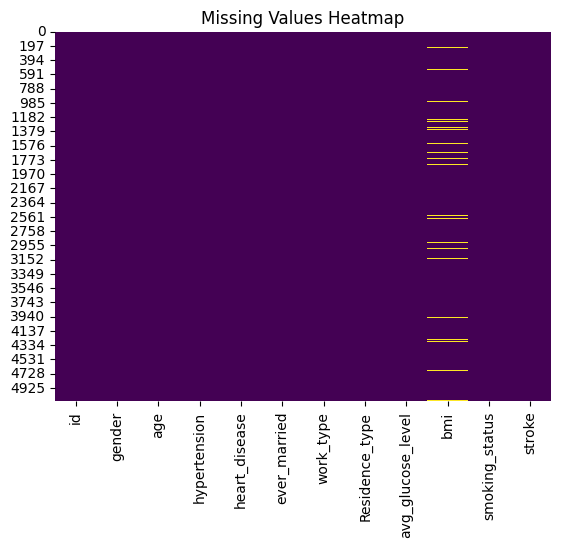

In [139]:
sns.heatmap(stroke_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()


# **Label encoding for categorical variables**

In [140]:
label_encoder = LabelEncoder()
for col in ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']:
    stroke_df[col] = label_encoder.fit_transform(stroke_df[col])


# **Handling missing values using KNN Imputation**

In [141]:
knn_imputer = KNNImputer(n_neighbors=3)
stroke_df['bmi'] = knn_imputer.fit_transform(stroke_df[['bmi']])
print(stroke_df.isnull().sum())


id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


# **Pairplot visualization**

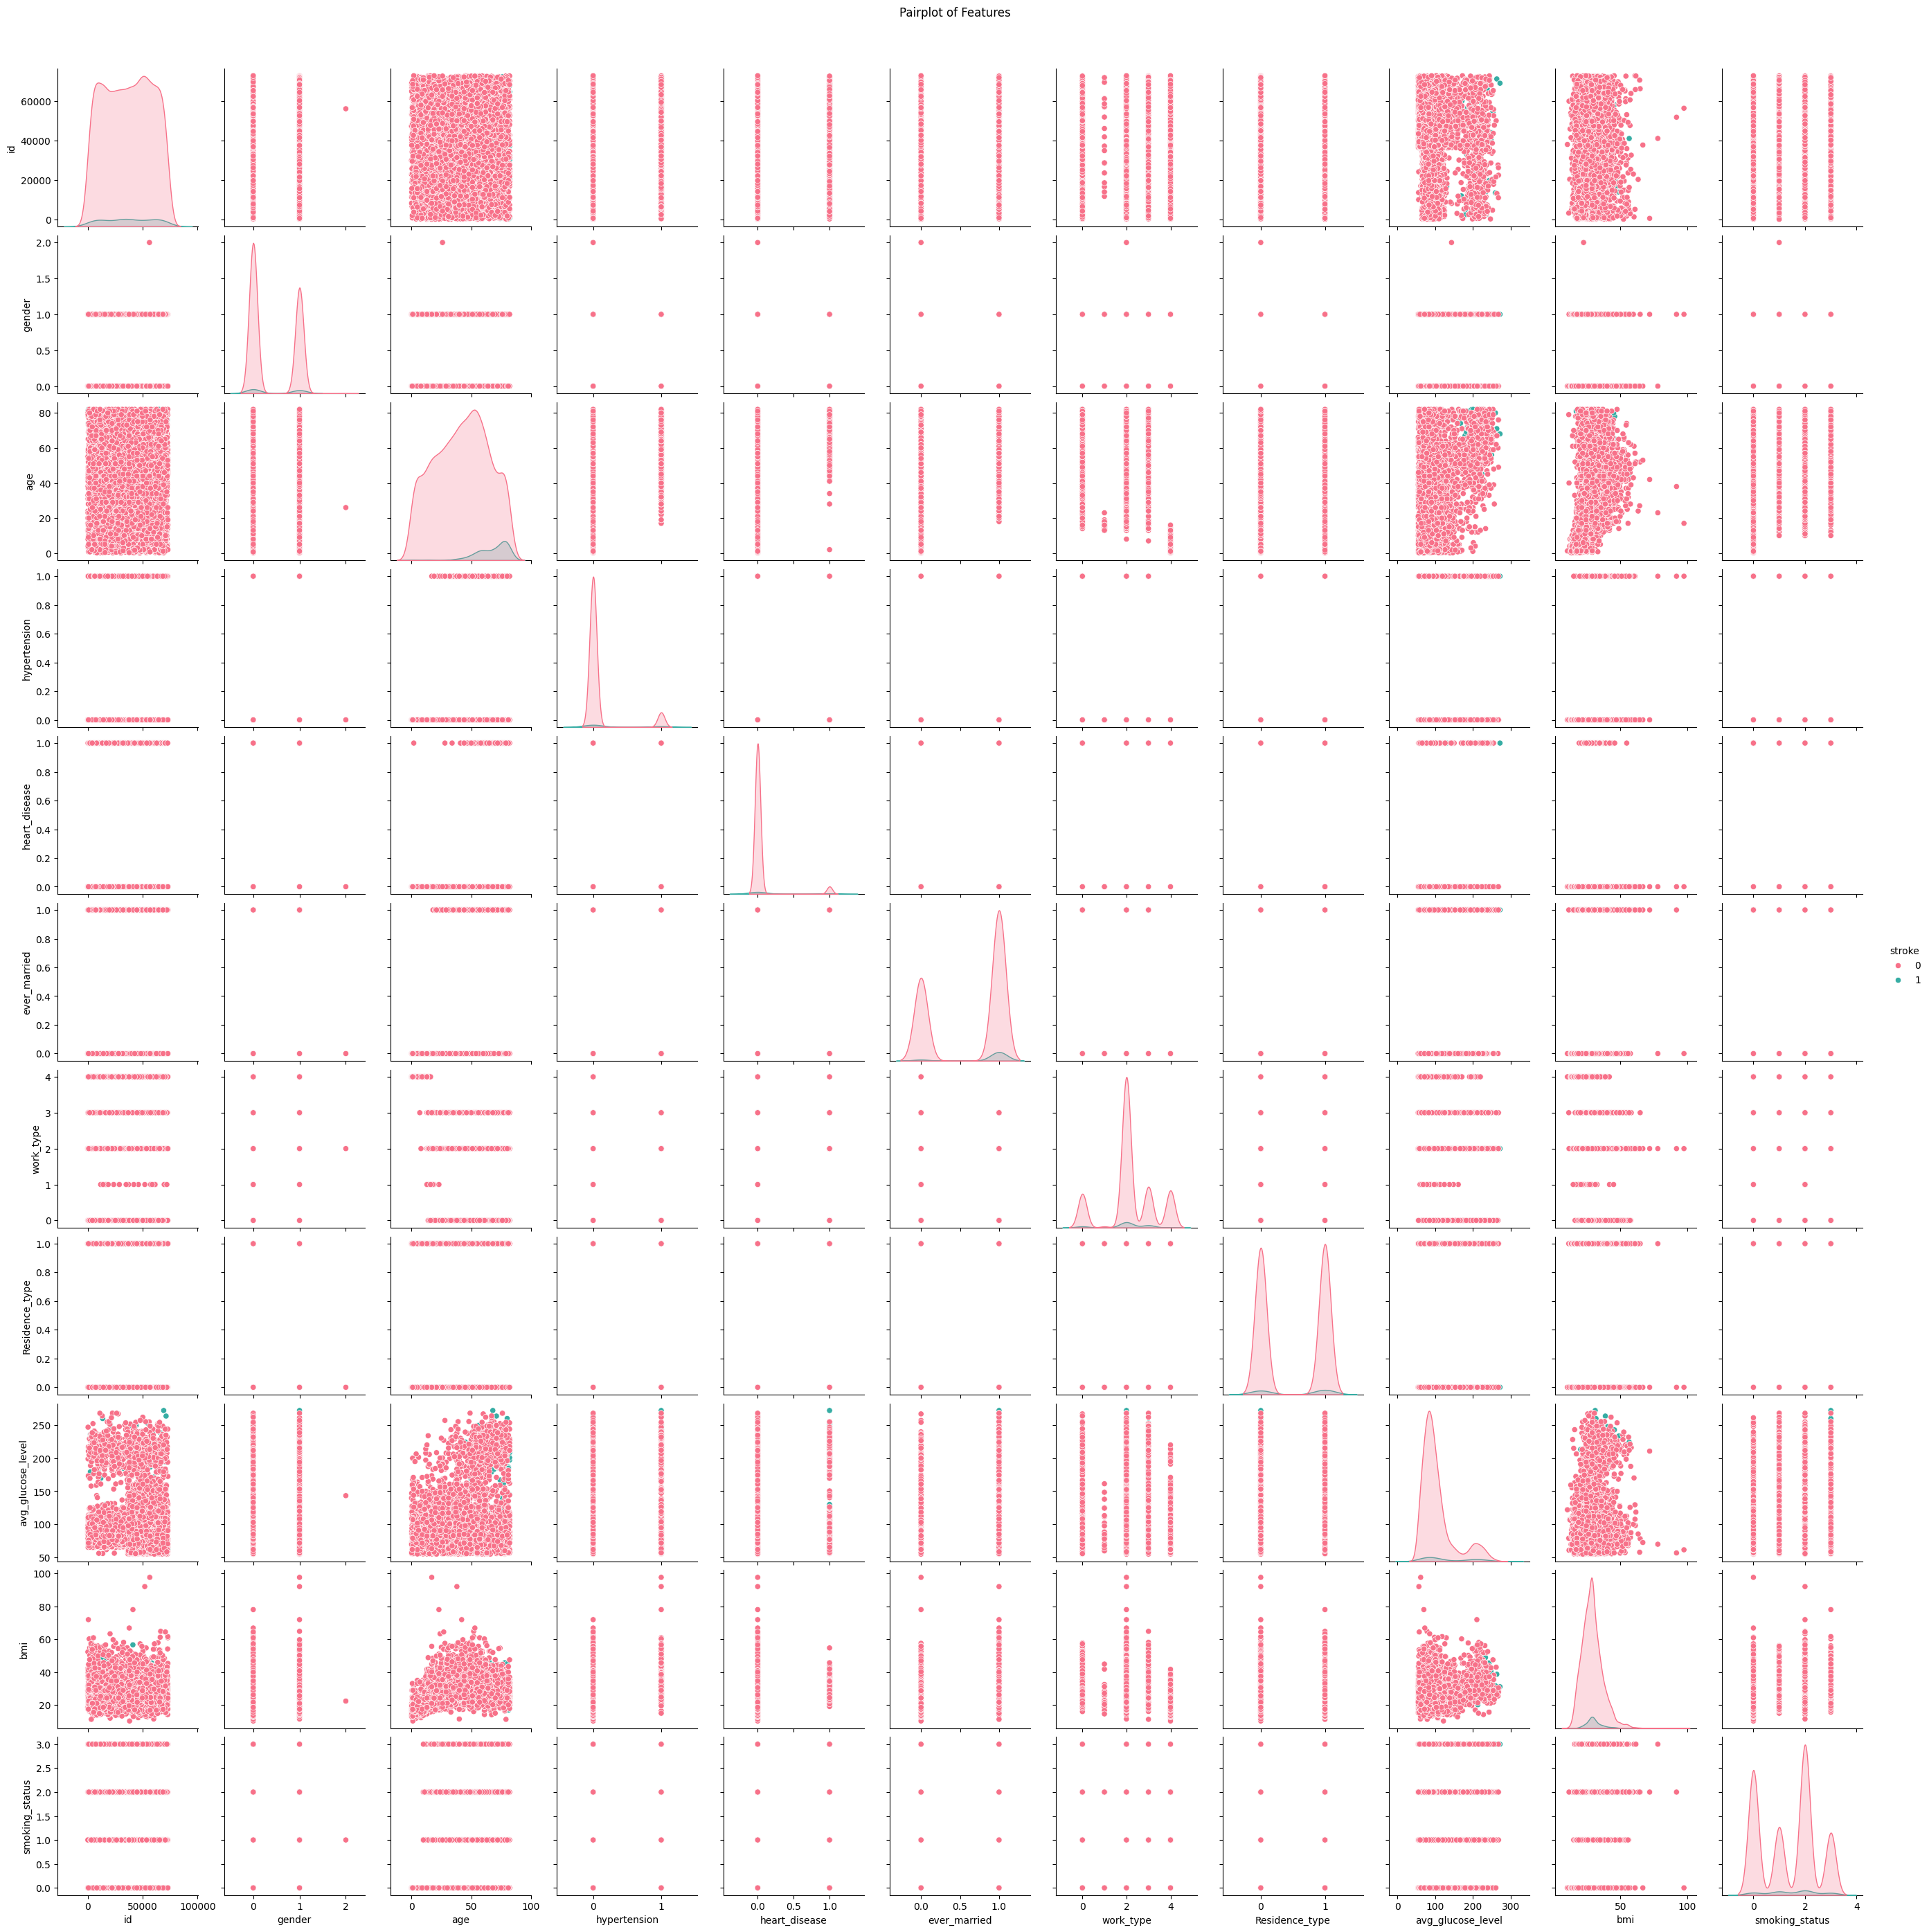

In [142]:
sns.pairplot(stroke_df, hue='stroke', diag_kind='kde', palette='husl')
plt.suptitle('Pairplot of Features', y=1.02)
plt.show()


# **Visualizing outliers using boxplots**

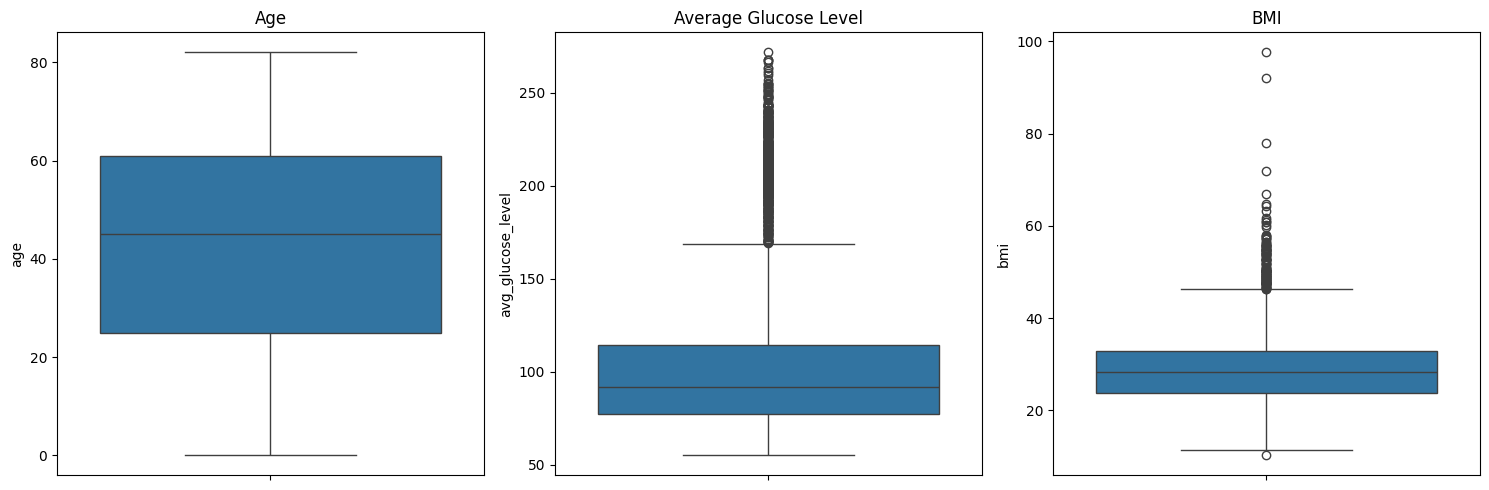

In [143]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.boxplot(data=stroke_df['age']).set_title('Age')

plt.subplot(1, 3, 2)
sns.boxplot(data=stroke_df['avg_glucose_level']).set_title('Average Glucose Level')

plt.subplot(1, 3, 3)
sns.boxplot(data=stroke_df['bmi']).set_title('BMI')
plt.tight_layout()
plt.show()


#  Distribution plots for continuous variables

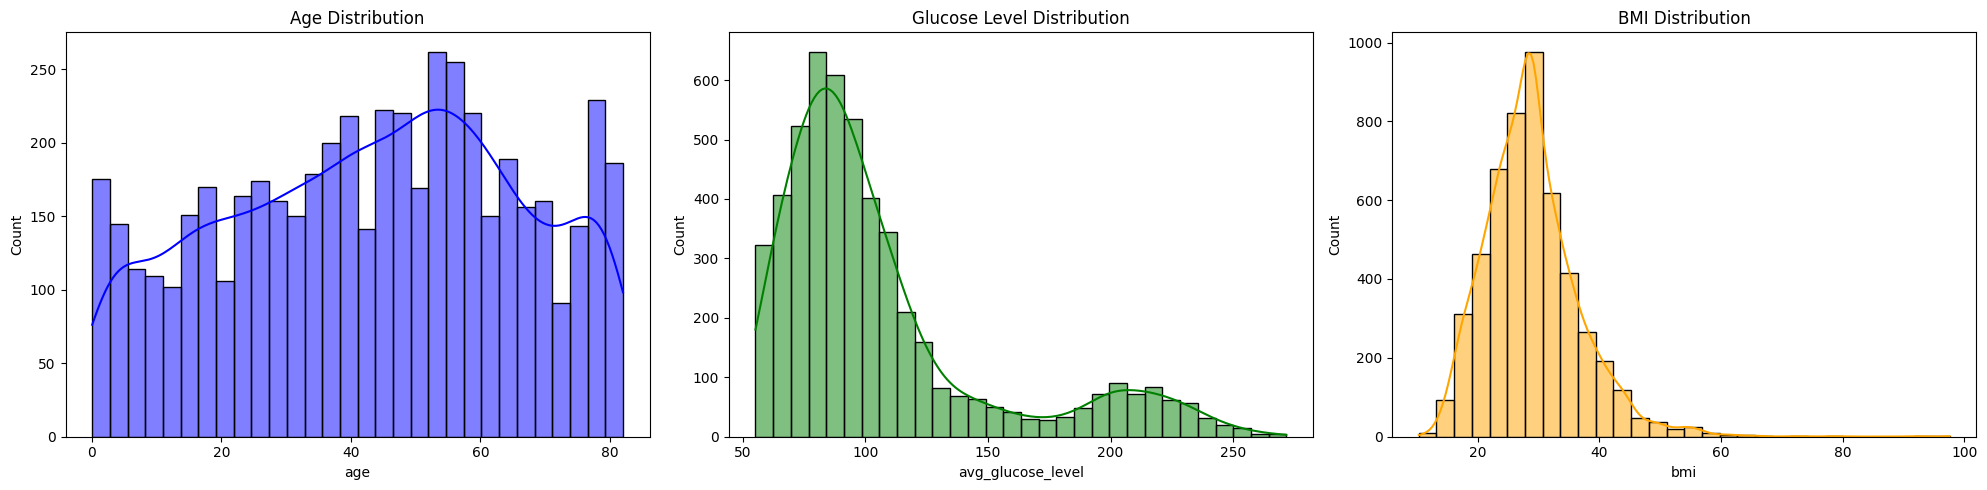

In [144]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
sns.histplot(stroke_df['age'], kde=True, bins=30, ax=axes[0], color='blue').set_title('Age Distribution')
sns.histplot(stroke_df['avg_glucose_level'], kde=True, bins=30, ax=axes[1], color='green').set_title('Glucose Level Distribution')
sns.histplot(stroke_df['bmi'], kde=True, bins=30, ax=axes[2], color='orange').set_title('BMI Distribution')
plt.tight_layout()
plt.show()


# **Correlation heatmap**

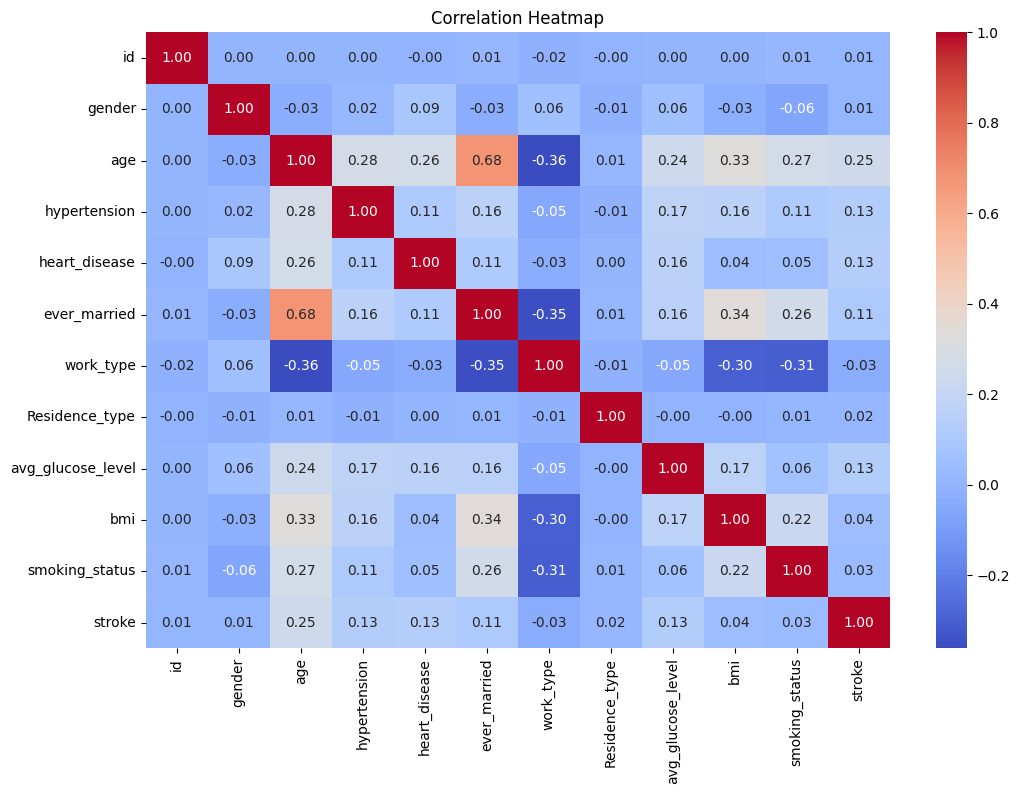

In [145]:
plt.figure(figsize=(12, 8))
correlation_matrix = stroke_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()


# **Handling outliers for 'avg_glucose_level'**

In [146]:
Q1 = np.percentile(stroke_df['avg_glucose_level'], 25)
Q3 = np.percentile(stroke_df['avg_glucose_level'], 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
mean_glucose = stroke_df['avg_glucose_level'].mean()
stroke_df.loc[stroke_df['avg_glucose_level'] > upper_bound, 'avg_glucose_level'] = mean_glucose
stroke_df.loc[stroke_df['avg_glucose_level'] < lower_bound, 'avg_glucose_level'] = mean_glucose


# **Class imbalance handling using SMOTE**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


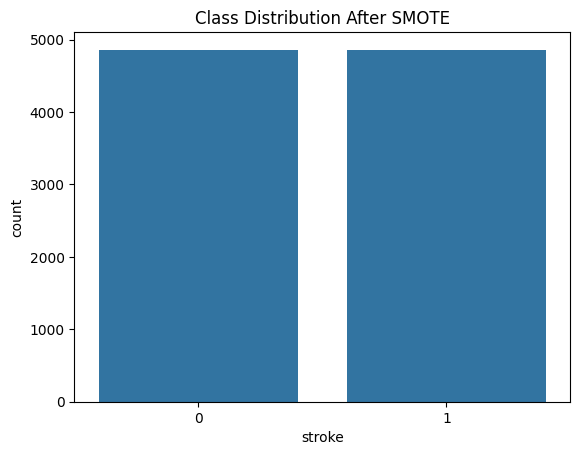

In [147]:
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(stroke_df.drop(['stroke'], axis=1), stroke_df['stroke'])

sns.countplot(x=y).set_title('Class Distribution After SMOTE')
plt.show()


# **Train-test split**

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


# **Naive Bayes Model**

In [149]:
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(X_train, y_train)
nb_pred = naive_bayes_model.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_pred)
print(f"Naive Bayes Accuracy: {nb_accuracy * 100:.2f}%")


Naive Bayes Accuracy: 79.92%


# **Decision Tree Model**

In [150]:
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train, y_train)
dt_pred = decision_tree_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_pred)
print(f"Decision Tree Accuracy: {dt_accuracy * 100:.2f}%")


Decision Tree Accuracy: 87.94%


# **Support Vector Machine (SVM) Model**

In [151]:
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)
print(f"SVM Accuracy: {svm_accuracy * 100:.2f}%")


SVM Accuracy: 80.53%


# **Logistic Regression Model**

In [154]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logistic_regression_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_regression_model.fit(X_train_scaled, y_train)
lr_pred = logistic_regression_model.predict(X_test_scaled)
lr_accuracy = accuracy_score(y_test, lr_pred)
print(f"Logistic Regression Accuracy: {lr_accuracy * 100:.2f}%")


Logistic Regression Accuracy: 82.31%


# **Comparison of model accuracies**

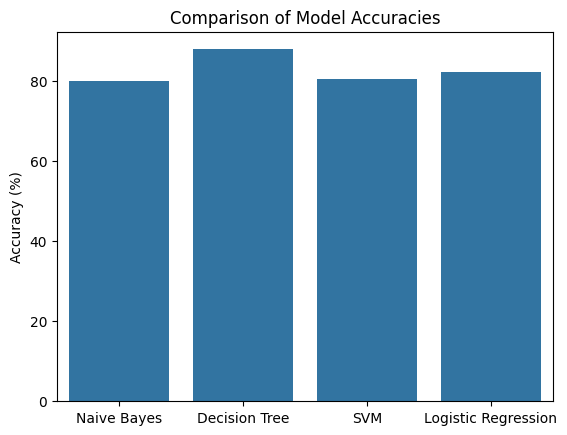

In [153]:
model_accuracies = {
    "Naive Bayes": nb_accuracy * 100,
    "Decision Tree": dt_accuracy * 100,
    "SVM": svm_accuracy * 100,
    "Logistic Regression": lr_accuracy * 100
}

sns.barplot(x=list(model_accuracies.keys()), y=list(model_accuracies.values()))
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Model Accuracies')
plt.show()
